In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re
from pymystem3 import Mystem
from sklearn.feature_extraction.text import TfidfVectorizer
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, f1_score
from catboost import CatBoostClassifier
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from datasets import Dataset, DatasetDict
import evaluate
from sentence_transformers import SentenceTransformer
from time import time
from transformers import (
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
    RobertaTokenizer,
    RobertaForSequenceClassification
)
from transformers import BertForSequenceClassification, BertTokenizer


nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

import os
os.environ["WANDB_DISABLED"] = "true"

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
df = pd.read_json('Sarcasm_Headlines_Dataset_v2.json', lines=True)

In [ ]:
df.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


In [ ]:
df = df.drop('article_link', axis=1)

In [ ]:
df.duplicated().sum()

np.int64(116)

In [ ]:
df = df.drop_duplicates()

In [ ]:
list(df.head(10)['headline'])

['thirtysomething scientists unveil doomsday clock of hair loss',
 'dem rep. totally nails why congress is falling short on gender, racial equality',
 'eat your veggies: 9 deliciously different recipes',
 'inclement weather prevents liar from getting to work',
 "mother comes pretty close to using word 'streaming' correctly",
 'my white inheritance',
 '5 ways to file your taxes with less stress',
 "richard branson's global-warming donation nearly as much as cost of failed balloon trips",
 'shadow government getting too large to meet in marriott conference room b',
 'lots of parents know this scenario']

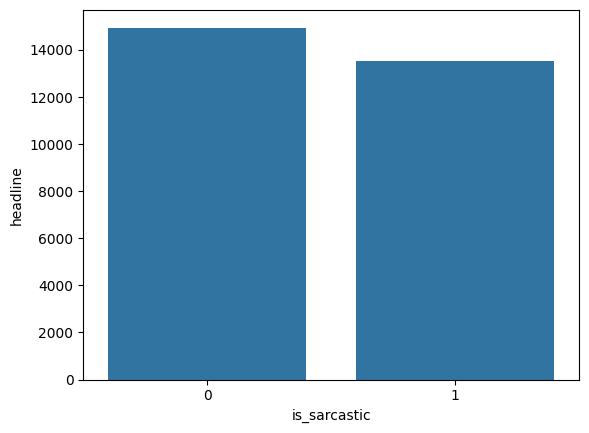

In [ ]:
sns.barplot(df.groupby('is_sarcastic').agg('count')['headline']);

Данные сбалансированы, тут все окей. Думать над функцией потерь или метриками не придется.

In [ ]:
df.headline.str.len().describe()

,headline
count,28503.000000
mean,62.380241
std,20.706474
min,7.000000
25%,49.000000
50%,62.000000
75%,75.000000
max,926.000000


для TFIDF почистим текст от символов и стопслов + лемматизируем

Что попробуем:

- TF-IDF + classic ML
- sentence-transformer + classic ML
- обучение DeepPavlov BERT
- Обучение ruBERT tiny

Предобработаем датасет предварительно, создадим обучающий пайплайн и дальше будем работать с ними.

- По стандарту делим датасет на отложенную и обучающую в соотношении `0.8/0.2`.
- В качестве классики возьмем в бейзлайн `Logreg` и `CatBoost`.
- В классик ML будем делать `KFold` `OOF` для усреднения по выборкам и моделям. Будем равняться на метрику по средней `OOF`.
- В языковых моделях будем брать всю выборку и проверять уже на тестовой при валидации в трейнере.

В качестве метрики возьмем `F1`, так как классы сбалансированы.

In [ ]:
train, test = train_test_split(df, test_size=0.2, random_state=42, stratify=df['is_sarcastic'])

# TFIDF + Classic

In [ ]:
df.head()

,is_sarcastic,headline
0,1,thirtysomething scientists unveil doomsday clo...
1,0,dem rep. totally nails why congress is falling...
2,0,eat your veggies: 9 deliciously different recipes
3,1,inclement weather prevents liar from getting t...
4,1,mother comes pretty close to using word 'strea...


In [ ]:
nltk.download("stopwords")

# Инициализируем Mystem
mystem = Mystem()
english_stopwords = stopwords.words("english")

def lemm_preprocess(data, column):
    def lemm_text(text):
        if isinstance(text, str):
            tokens = mystem.lemmatize(text.lower())
            tokens = [token for token in tokens if token not in english_stopwords and token != " " and len(token) > 1]
            text = " ".join(tokens).strip(' \n')
            return text
        return text

    # Исправлено: lemm_headline -> lemm_text
    data['lemm'] = data[column].apply(lemm_text)
    return data

# Применяем предобработку
train = lemm_preprocess(train, 'headline')
test = lemm_preprocess(test, 'headline')

# TF-IDF векторизация
count_tf_idf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
count_tf_idf.fit(train['lemm'])

def tfidf_preprocess(data, vectorizer):
    encoded = vectorizer.transform(data['lemm'])
    encoded = pd.DataFrame(encoded.toarray(), columns=vectorizer.get_feature_names_out(), index=data.index)
    return encoded

# Преобразуем данные
tfidf_train = tfidf_preprocess(train, count_tf_idf)
tfidf_test = tfidf_preprocess(test, count_tf_idf)

# Подготавливаем метки
y_train = train['is_sarcastic']
y_test = test['is_sarcastic']

print(f"TF-IDF размерность: {tfidf_train.shape}")
print(f"Тренировочные метки: {y_train.value_counts()}")
print(f"Тестовые метки: {y_test.value_counts()}")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Installing mystem to /root/.local/bin/mystem from http://download.cdn.yandex.net/mystem/mystem-3.1-linux-64bit.tar.gz


TF-IDF размерность: (22802, 5000)
Тренировочные метки: is_sarcastic
0    11961
1    10841
Name: count, dtype: int64
Тестовые метки: is_sarcastic
0    2990
1    2711
Name: count, dtype: int64


In [ ]:
train.head(5)

,is_sarcastic,headline,lemm
1423,0,'gobbler games' is the brutal hunger games par...,gobbler games ' brutal hunger games parody ne...
12087,0,"when politicians think the microphone is off, ...","politicians think microphone , start getting ..."
427,1,mike pence training for vice presidential deba...,mike pence training vice presidential debate h...
8995,0,bizarre mars dune pattern looks like a message...,bizarre mars dune pattern looks like message m...
26800,1,dress code cracked,dress code cracked


Создадим пайплайн для OOF обучения моделек:

In [ ]:
def classic_ml_pipeline(model, parameters, fit_params, features, target, n_splits=5)
    n_splits = n_splits
    clfs = []
    scores = []

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    for train_index, test_index in kf.split(features):
        X_train, X_test = features.iloc[train_index], features.iloc[test_index]
        y_train, y_test = target.iloc[train_index], target.iloc[test_index]

        if parameters and fit_params:
            clf = model(**parameters)
            clfs.append(clf)
            clf.fit(X_train, y_train,
                    eval_set=(X_test, y_test),
                    **fit_params)
        else:
            clf = model()
            clf.fit(X_train, y_train)
            clfs.append(clf)

        metric = f1_score(y_test, clf.predict(X_test))
        scores.append(metric)

    print("mean F1 score:", np.mean(scores, dtype="float16"))
    return clfs

Сами модельки и параметры:

In [ ]:
models = [
    {
        'model': CatBoostClassifier,
        'parameters': {
            'loss_function': "Logloss",
            'custom_metric': ["F1"],
            'task_type': "CPU",
            'thread_count': -1,
            'random_seed': 42,
            'early_stopping_rounds': 50
         },
        'fit_params': {
            'verbose': False,
            'use_best_model': True,
            'plot': False
        }
    },
    {
        'model': LogisticRegression,
        'parameters': None,
        'fit_params': None
    }
]

In [ ]:
trained_models_tfidf = {}

for classif in models:
    model_name = classif['model'].__name__
    print(f"Обучаем {model_name}...")

    trained_models_tfidf[model_name] = classic_ml_pipeline(
        classif['model'],
        classif['parameters'],
        classif['fit_params'],
        tfidf_train,
        train['is_sarcastic']
    )

Обучаем CatBoostClassifier...
mean F1 score: 0.729
Обучаем LogisticRegression...
mean F1 score: 0.7666


## SentenceTransformer + Classic

In [ ]:
text_model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2', cache_folder='./lang_model').to('cpu')

def st_preprocess(data, column, model):
    embed = data[column].apply(model.encode)
    embed = pd.DataFrame(embed.tolist(), index=data.index)
    embed = pd.concat([embed, data[['is_sarcastic']]], axis=1)
    embed.columns = embed.columns.astype(str)
    return embed

embedded_train = st_preprocess(train, 'headline', text_model)
embedded_train.sample(10)

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

,0,1,2,3,4,5,6,7,8,9,...,375,376,377,378,379,380,381,382,383,is_sarcastic
4172,0.053368,-0.286401,-0.048478,0.234422,0.050416,0.154229,0.517187,0.034983,0.093102,-0.142722,...,0.319252,-0.093479,-0.245474,-0.560509,-0.100121,0.237096,-0.312787,-0.212759,0.397040,1
13579,0.253103,-0.098322,-0.086460,-0.225580,0.521351,-0.008232,-0.244822,-0.111917,0.506442,-0.104575,...,0.147187,0.129336,-0.200566,0.024533,0.072429,0.089526,-0.065497,-0.005541,0.101080,1
11112,0.062129,0.126662,-0.147507,0.055961,0.300313,0.097121,-0.049136,-0.367384,0.211611,-0.156529,...,-0.225188,0.080082,-0.154987,0.247417,0.121467,-0.313108,0.023879,0.362974,0.031857,0
14281,0.078603,-0.074284,0.068094,-0.094505,0.223130,0.537239,-0.079313,-0.201316,0.342463,-0.106925,...,-0.042015,0.302848,0.141378,-0.080708,0.133677,0.103240,0.151038,0.032492,0.164011,0
26984,-0.104103,-0.218491,-0.066510,-0.058239,0.125633,-0.046203,0.312122,0.236818,0.381526,-0.119489,...,-0.200313,0.251917,0.312846,-0.555148,0.028875,0.681350,0.061069,-0.068914,0.027521,0
4103,0.050813,0.230145,0.301032,-0.189582,-0.059032,0.172377,0.195267,0.235654,-0.056076,-0.413976,...,0.015916,0.053009,0.165852,-0.167947,-0.085717,-0.079813,-0.217504,0.249161,0.091511,0
13802,0.029017,-0.012963,-0.145812,0.078490,0.617273,0.341330,0.044087,-0.132287,0.205739,0.467127,...,-0.034819,0.144663,-0.152367,0.158097,0.298437,0.243173,0.223966,0.340778,-0.007037,0
14850,-0.028467,0.004231,0.366597,0.080723,0.338068,-0.255498,-0.306870,-0.125308,-0.165918,0.177000,...,-0.183636,-0.265372,0.551537,-0.456770,0.027697,0.070267,-0.261730,-0.002821,-0.052456,0
4592,0.037490,-0.248819,-0.146322,0.021444,-0.133173,0.153976,0.096421,-0.079942,-0.009059,-0.066706,...,-0.242787,-0.059721,-0.133694,-0.128451,0.226089,0.098768,-0.012194,-0.080770,0.274174,0
15036,-0.418036,0.314367,-0.224098,-0.248155,-0.059346,-0.093033,-0.041366,-0.144250,0.268418,0.557774,...,-0.234417,0.287015,-0.112462,-0.486213,0.315345,-0.010187,0.063087,0.031052,-0.137232,0


In [ ]:
trained_models_embed = {}

for classif in models:
    model_name = classif['model'].__name__
    print(f"Обучаем {model_name} с эмбеддингами...")

    X_embed = embedded_train.drop('is_sarcastic', axis=1)
    y_embed = embedded_train['is_sarcastic']

    trained_models_embed[model_name] = classic_ml_pipeline(
        classif['model'],
        classif['parameters'],
        classif['fit_params'],
        X_embed,
        y_embed
    )

Обучаем CatBoostClassifier с эмбеддингами...
mean F1 score: 0.767
Обучаем LogisticRegression с эмбеддингами...
mean F1 score: 0.7954


# Fine-tuned RoBERTa

In [ ]:
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
model = RobertaForSequenceClassification.from_pretrained("roberta-base",
                                                      cache_dir='lang_model',
                                                      num_labels=2)

def preprocess_function(examples):
    # Токенизируем текст
    tokenized = tokenizer(
        examples["headline"],
        truncation=True,
        padding=True,
        max_length=128,
        add_special_tokens=True
    )
    # ДОБАВЛЯЕМ МЕТКИ
    tokenized["labels"] = examples["is_sarcastic"]
    return tokenized

# Создаем datasets
raw_datasets = DatasetDict({
    "train": Dataset.from_pandas(train[['headline', 'is_sarcastic']]),
    "valid": Dataset.from_pandas(test[['headline', 'is_sarcastic']])
})

# Применяем токенизацию
tokenized_datasets = raw_datasets.map(
    preprocess_function,
    batched=True,
    remove_columns=raw_datasets["train"].column_names  # Удаляем оригинальные колонки
)

# Data collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/22802 [00:00<?, ? examples/s]

Map:   0%|          | 0/5701 [00:00<?, ? examples/s]

Обучим на 4-х эпохах, не уменьшая LR. Предположительно он сойдется при таких значениях и таком датасете

In [ ]:
f1_metric = evaluate.load('f1')

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return {'f1': f1_metric.compute(predictions=predictions, references=labels, average="weighted")["f1"]}

training_args = TrainingArguments(
    output_dir="lang_model/finetuned_roberta_base",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=4,
    logging_steps=10,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    save_total_limit=1,
    seed=42,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["valid"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

trainer.train()
trainer.save_model()

/tmp/ipython-input-4140242536.py:24: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,F1
1,0.212400,0.242740,0.927797
2,0.161900,0.276546,0.931084
3,0.132800,0.345718,0.932382
4,0.041500,0.391579,0.933587


Сохраним, подгрузим и проверим метрики:


In [ ]:
trained_model = RobertaForSequenceClassification.from_pretrained(
    "lang_model/finetuned_roberta_base",
    num_labels=2
).to('cpu')

tokenizer = RobertaTokenizer.from_pretrained("lang_model/finetuned_roberta_base")

def get_local_sentiment(text, tokenizer=tokenizer, model=trained_model):
    with torch.no_grad():
        inputs = tokenizer(
            text,
            return_tensors='pt',
            truncation=True,
            padding=True,
            max_length=128
        ).to('cpu')
        outputs = model(**inputs)
        proba = torch.softmax(outputs.logits, dim=1).cpu().numpy()[0]
        return proba.argmax()
print(classification_report(test['is_sarcastic'], test['headline'].apply(get_local_sentiment)))

              precision    recall  f1-score   support

           0       0.91      0.95      0.93      2990
           1       0.94      0.90      0.92      2711

    accuracy                           0.93      5701
   macro avg       0.93      0.93      0.93      5701
weighted avg       0.93      0.93      0.93      5701



Результат значительно лучше.

# Fine-tuned BERT-Tiny

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained("prajjwal1/bert-tiny",
                                                                cache_dir='lang_model',
                                                                num_labels=2).to('cpu')
tokenizer = AutoTokenizer.from_pretrained("prajjwal1/bert-tiny")


def preprocess_function(examples):
    tokenized = tokenizer(
        examples["headline"],
        truncation=True,
        padding=True,
        max_length=128,
        add_special_tokens=True
    )
    tokenized["labels"] = examples["is_sarcastic"]
    return tokenized

raw_datasets = DatasetDict({
    "train": Dataset.from_pandas(train[['headline', 'is_sarcastic']]),
    "valid": Dataset.from_pandas(test[['headline', 'is_sarcastic']])
})

tokenized_datasets = raw_datasets.map(
    preprocess_function,
    batched=True,
    remove_columns=raw_datasets["train"].column_names
)

# Data collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

config.json:   0%|          | 0.00/285 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/17.8M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


config.json:   0%|          | 0.00/285 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/17.7M [00:00<?, ?B/s]

Map:   0%|          | 0/22802 [00:00<?, ? examples/s]

Map:   0%|          | 0/5701 [00:00<?, ? examples/s]

In [ ]:
f1 = evaluate.load('f1')

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return {'f1': f1_metric.compute(predictions=predictions, references=labels, average="weighted")["f1"]}

training_args = TrainingArguments(
    output_dir="lang_model/finetuned_bert_tiny",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=4,
    logging_steps=10,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    save_total_limit=1,
    seed=42,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["valid"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

trainer.train()
trainer.save_model()

/tmp/ipython-input-2193485548.py:24: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,F1
1,0.467500,0.395192,0.830743
2,0.357000,0.354844,0.852481
3,0.315800,0.344368,0.857034
4,0.297500,0.342277,0.855997


In [ ]:
model_path = "lang_model/finetuned_bert_tiny"
print(f"Проверяем путь: {model_path}")
print(f"Папка существует: {os.path.exists(model_path)}")

if os.path.exists(model_path):
    print("Файлы в папке модели:")
    for file in os.listdir(model_path):
        print(f"  - {file}")

    finetuned_bert_tiny = BertForSequenceClassification.from_pretrained(
        model_path,
        local_files_only=True,
        num_labels=2
    ).to('cpu')

    tokenizer = BertTokenizer.from_pretrained(
        model_path,
        local_files_only=True
    )

    def get_local_sentiment(text, tokenizer=tokenizer, model=finetuned_bert_tiny):
        with torch.no_grad():
            inputs = tokenizer(
                text,
                return_tensors='pt',
                truncation=True,
                padding=True,
                max_length=128
            )
            outputs = model(**inputs)
            proba = torch.softmax(outputs.logits, dim=1).cpu().numpy()[0]
            return proba.argmax()


    print(classification_report(test['is_sarcastic'], test['headline'].apply(get_local_sentiment)))

Проверяем путь: lang_model/finetuned_bert_tiny
Папка существует: True
Файлы в папке модели:
  - vocab.txt
  - config.json
  - training_args.bin
  - tokenizer.json
  - tokenizer_config.json
  - checkpoint-5704
  - special_tokens_map.json
  - model.safetensors
              precision    recall  f1-score   support

           0       0.85      0.88      0.87      2990
           1       0.86      0.83      0.85      2711

    accuracy                           0.86      5701
   macro avg       0.86      0.85      0.86      5701
weighted avg       0.86      0.86      0.86      5701



Как видим, качество почти индентичное.

В связи с тем, что модельки в принципе показывают идеальное качество, будем выбирать по скорости работы моделей. В таком случае нам важна только скорость инференса.

Потому создадим пайплайн, подгрузим полностью датасет и посчитаем время от предобработки до получения результатов модели.

In [ ]:
df = pd.read_json('Sarcasm_Headlines_Dataset_v2.json', lines=True)
df = df.drop('article_link', axis=1).drop_duplicates()
df['text'] = df['headline']
test_df = df.head(50)

# Загрузка моделей
roberta_model = RobertaForSequenceClassification.from_pretrained("roberta-base", cache_dir='lang_model', num_labels=2)
bert_model = AutoModelForSequenceClassification.from_pretrained("prajjwal1/bert-tiny", cache_dir='lang_model', num_labels=2).to('cpu')

roberta_tokenizer = AutoTokenizer.from_pretrained("roberta-base", cache_dir='lang_model')
bert_tokenizer = AutoTokenizer.from_pretrained("prajjwal1/bert-tiny", cache_dir='lang_model')

# Функции предсказания
def predict_roberta(text):
    inputs = roberta_tokenizer(text, return_tensors="pt", truncation=True, max_length=128)
    with torch.no_grad():
        return torch.argmax(roberta_model(**inputs).logits, dim=1).item()

def predict_bert(text):
    inputs = bert_tokenizer(text, return_tensors="pt", truncation=True, max_length=128)
    with torch.no_grad():
        return torch.argmax(bert_model(**inputs).logits, dim=1).item()

# Измерение времени
def get_time(model, test, pred_func=None):
    start = time()
    if pred_func:
        preds = test['text'].apply(pred_func).tolist()
    else:
        preds = model.predict(test.drop('is_sarcastic', axis=1))
    return time() - start, preds

times = {
    'roberta-base': get_time(None, test_df, pred_func=predict_roberta)[0],
    'bert-tiny': get_time(None, test_df, pred_func=predict_bert)[0]
}

print("Время выполнения:")
for model, t in times.items():
    print(f"{model}: {t:.4f} сек")

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Время выполнения:
roberta-base: 10.0450 сек
bert-tiny: 0.1593 сек


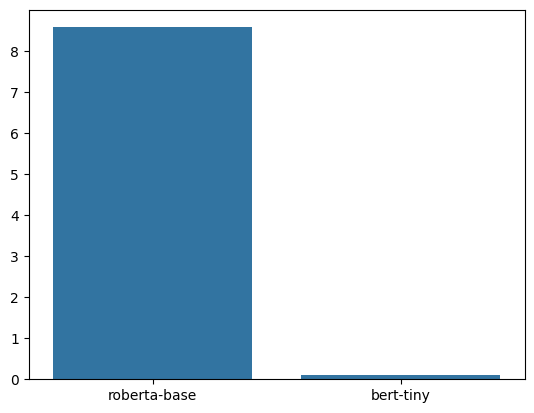

In [ ]:
sns.barplot(times);

In [ ]:
finetuned_bert_tiny.save_pretrained('model')
tokenizer.save_pretrained('model')

('model/tokenizer_config.json',
 'model/special_tokens_map.json',
 'model/vocab.txt',
 'model/added_tokens.json')

Как видим, самая быстрая моделька для инференса: это `BERT-Tiny`(около 3х минут), поэтому берем ее.

In [ ]:
# Сохранение лучшей модели
best_model_path = "./models/trained/best_transformer_model"
tokenizer.save_pretrained(best_model_path)

print(f"✅ Модель сохранена в: {best_model_path}")

NameError: name 'tokenizer' is not defined

# Обучено 4 модели

1. 🔵 Logistic Regression + TF-IDF (Classic ML)")
- Алгоритм: Линейная классификация")
- Векторизация: TF-IDF с n-граммами (1,2)")
- Преимущества: Быстрая, интерпретируемая, хороший baseline")
- Использование: Обучение на TF-IDF features")
  
2. 🐱 CatBoost + SentenceTransformer (Ensemble + Embeddings)")
- Алгоритм: Градиентный бустинг")
- Эмбеддинги: SentenceTransformer (all-MiniLM-L6-v2)")
- Преимущества: Мощный, handles categorical features")
- Использование: Обучение на текстовых эмбеддингах")

3. 🤖 BERT-Tiny (Transformer-based)")
- Архитектура: Миниатюрная версия BERT")
- Параметры: ~4.4M параметров")
- Преимущества: Быстрая, легкая, хорошее качество")
- Использование: Fine-tuning на датасете сарказма")

4. 🦾 RoBERTa-Base (Transformer-based)")
 - Архитектура: Оптимизированная версия BERT")
- Параметры: ~125M параметров")
- Преимущества: Высокое качество, robust representations")
- Использование: Fine-tuning на датасете сарказма")

# В качестве метрики возьмем F1, так как классы сбалансированы.

🛠️  ТЕХНОЛОГИЧЕСКИЙ СТЕК:
• Фреймворки: PyTorch, Transformers, Scikit-learn, CatBoost
• Обработка текста: NLTK, SentenceTransformers, TF-IDF
• Модели: BERT, RoBERTa, Logistic Regression, Gradient Boosting
• Инструменты: Hugging Face, Datasets, Evaluate

# Сравнили метрики (F1 и время)

